# Importing Libraries

In [1]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.1 MB/s eta 0:00:00


In [2]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

# Reading Dataset

In [3]:
df_ =pd.read_csv("/kaggle/input/online-retail-ii-uci/online_retail_II.csv")
df = df_.copy()
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.1000,12680.0000,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.1500,12680.0000,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.1500,12680.0000,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.9500,12680.0000,France
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.0000,12680.0000,France


In [4]:
df.shape

(1067371, 8)

In [5]:
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

In [6]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0000,9.9389,172.7058,-80995.0000,1.0000,3.0000,10.0000,80995.0000
Price,1067371.0000,4.6494,123.5531,-53594.3600,1.2500,2.1000,4.1500,38970.0000
Customer ID,824364.0000,15324.6385,1697.4645,12346.0000,13975.0000,15255.0000,16797.0000,18287.0000


# Data Preprocessing

In [8]:
df.dropna(inplace=True)
df = df[df['Quantity']>0]
df = df[df['Price']>0]

In [9]:
describe_list = [0.01, 0.05, 0.95, 0.99]
df.describe(describe_list).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
Quantity,805549.0000,13.2905,143.6341,1.0000,1.0000,1.0000,5.0000,36.0000,128.0000,80995.0000
Price,805549.0000,3.2066,29.1992,0.0010,0.2900,0.4200,1.9500,8.5000,14.9500,10953.5000
Customer ID,805549.0000,15331.9550,1696.7370,12346.0000,12422.0000,12681.0000,15271.0000,17913.0000,18204.0000,18287.0000


## Outliers

In [10]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, 'Quantity')
replace_with_thresholds(df, 'Price')

In [11]:
df['Total_Price'] = df['Quantity']*df['Price']
df['Customer ID'] = df['Customer ID'].astype(int)

In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [13]:
#Analysis Date
today_date = dt.datetime(2011, 12, 10)

# Feature Engineering
## *Preparing Lifetime Data Structure*


*   Recency: Time since last purchase. Weekly. (user specific)
*   Tenure: T: Customer age. Weekly. (how long ago was the first purchase made before the analysis date)
*   Frequency: total number of repeat purchases (frequency>1)
*   Monetary: average earnings per purchase

In [14]:
cltv_df = df.groupby('Customer ID').agg({'InvoiceDate':[lambda x: (x.max()- x.min()).days,
                                                        lambda x: (today_date - x.min()).days],
                                         'Invoice':lambda x: x.nunique(),
                                         'Total_Price':lambda x: x.sum()})

In [15]:
cltv_df

InvoiceDate             Invoice Total_Price
             <lambda_0> <lambda_1> <lambda>    <lambda>
Customer ID                                            
12346               400        725       12    704.1000
12347               402        404        8   5633.3200
12348               362        438        5   1991.8600
12349               570        589        4   3786.5000
12350                 0        310        1    331.3400
...                 ...        ...      ...         ...
18283               654        658       22   2736.6500
18284                 0        431        1    448.6200
18285                 0        660        1    413.9400
18286               247        723        2   1283.3700
18287               528        571        7   4169.9300

[5878 rows x 4 columns]

In [16]:
cltv_df.columns = cltv_df.columns.droplevel(0)


In [17]:
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df["recency"] = cltv_df["recency"] / 7 #Weekly
cltv_df["T"] = cltv_df["T"] / 7 #Weekly

In [18]:
cltv_df

,recency,T,frequency,monetary
Customer ID,,,,
12346,57.1429,103.5714,12,58.6750
12347,57.4286,57.7143,8,704.1650
12348,51.7143,62.5714,5,398.3720
12349,81.4286,84.1429,4,946.6250
12352,50.8571,56.0000,10,209.8940
...,...,...,...,...
18281,56.7143,82.4286,2,100.5700
18282,16.8571,18.0000,2,89.0250
18283,93.4286,94.0000,22,124.3932


# BG/NBD MODEL

The Beta-Geometric (BG) model predicts future purchasing behavior through customer purchase frequency and churn probability.

In [19]:
bgf = BetaGeoFitter(penalizer_coef=0.001) #For preventing overfit
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 4255 subjects, a: 0.23, alpha: 11.20, b: 3.05, r: 1.71>

In [20]:
#Who are the 5 customers we expect to purchase the most from in 1 week?
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head()

Customer ID
14911   3.4206
12748   2.9004
17841   1.8209
15311   1.7944
13089   1.7514
dtype: float64

In [21]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

In [22]:
#Who are the 5 customers we expect to purchase the most from in 1 month?
#conditional_expected_number_of_purchases_up_to_time = predict
bgf.predict(4, #4 week =1 month
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head()

Customer ID
14911   13.6421
12748   11.5673
17841    7.2622
15311    7.1563
13089    6.9850
dtype: float64

In [23]:
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [24]:
#What is the total purchase estimate in 1 month?
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

1728.0957566251843

# Evaluation of Forecast Results

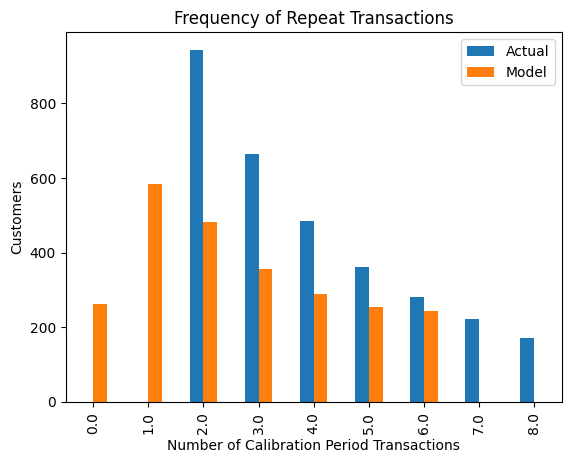

In [25]:
plot_period_transactions(bgf)
plt.show()

# GAMMA-GAMMA MODEL

The Gamma-Gamma model analyzes customers' spending behavior through purchase frequency and average earnings.

Gamma-Gamma Model >> Frequency and Average Earnings per Purchase


In [26]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
ggf.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary']).sort_values(ascending=False).head(5)

Customer ID
12357   6182.8322
12590   5035.2460
12415   5034.5651
14091   4997.1846
14088   4029.9276
dtype: float64

In [27]:
cltv_df['expected_average_profit'] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

# Calculation of Customer Lifetime Valur with BG-NBD and GG model.

In [28]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3, #3 months
                                   freq='W', #weekly,
                                   discount_rate=0.01)
cltv.head()

Customer ID
12346      4.2268
12347   1241.3282
12348    430.2993
12349    714.7248
12352    444.9096
Name: clv, dtype: float64

In [29]:
cltv= cltv.reset_index()
cltv_final = cltv.merge(cltv_df, how='right', on='Customer ID')
cltv_final.sort_values(by="clv", ascending=False).head()

,Customer ID,clv,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit
4139,18102,59139.1717,105.4286,105.4286,145,3726.6687,1.2547,5.0041,3731.1484
1652,14646,55553.9211,105.0000,105.2857,151,3361.4186,1.3068,5.2118,3365.3009
1290,14156,32189.2762,104.0000,105.4286,156,1903.5948,1.3371,5.3326,1905.7332
1840,14911,30666.7566,105.2857,105.4286,398,709.3988,3.4206,13.6421,709.7169
3682,17450,29636.9648,61.2857,62.5714,51,3334.3318,0.7056,2.8093,3345.7601


# Customer Segmentation Based on CLTV

In [30]:
cltv_final['segment'] = pd.qcut(cltv_final['clv'], 4, labels=['D', 'C', 'B', 'A'])

In [31]:
cltv_final.groupby('segment').agg({'count', 'mean', 'sum'})

Customer ID                           clv                    recency                        T               frequency                  monetary                expected_purc_1_week              expected_purc_1_month              expected_average_profit               
                sum       mean count          sum      mean count        sum    mean count        sum    mean count       sum    mean count         sum     mean count                  sum   mean count                   sum   mean count                     sum     mean count
segment                                                                                                                                                                                                                                                                           
D          16391893 15405.9145  1064   34662.8542   32.5779  1064 29869.1429 28.0725  1064 86866.5714 81.6415  1064      4226  3.9718  1064 269976.3090 253.7371  1064              16.0434 0.0151  1064               63.9188 0.0601  1064             289387.2062 271.9805  1064
C          16484923 15493.3487  1064  191417.4498  179.9036  1064 63463.8571 59.6465  1064 80555.4286 75.7100  1064      4835  4.5442  1064 279312.7390 262.5120  1064              66.4381 0.0624  1064              264.4574 0.2486  1064             296513.1530 278.6778  1064
B          16226708 15265.0122  1063  436084.7647  410.2397  1063 67088.1429 63.1121  1063 75515.2857 71.0398  1063      7733  7.2747  1063 373780.4297 351.6279  1063             112.9679 0.1063  1063              449.3528 0.4227  1063             390119.6290 366.9987  1063
A          16039842 15075.0395  1064 1755556.9932 1649.9596  1064 68839.7143 64.6990  1064 73061.5714 68.6669  1064     18552 17.4361  1064 631554.0525 593.5658  1064             239.0323 0.2247  1064              950.3668 0.8932  1064             650046.4289 610.9459  1064